In [13]:
### tol 5 o 3??

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
label_names = ['not app', 'no person', 'yes', 'no'] # Q4: Person wearing fashion?
folder = "./Fashion10000/"

### Load Data and preprocess

In [4]:
X_vgg16 = np.load(folder+"Fashion10000_VGG_avg_all.npy")
X_vgg16.shape

(31077, 512)

In [5]:
Q_s = "Q4" #question selected
p_error = "0.6" #Q3: cerca de 82-84.. valores varian 2% 

In [6]:
sets = np.loadtxt(folder+"sets_"+p_error+"_"+Q_s+".txt", dtype='U')
mask_train = sets == "train"
mask_test = sets == "test"

Z_data = np.loadtxt(folder+"Z_data_"+Q_s+".txt",dtype='int')
Z_train = Z_data[mask_train]
Z_test = Z_data[mask_test]

X_train_vgg16 = X_vgg16[mask_train]
X_test_vgg16 = X_vgg16[mask_test]

X_val_vgg16 = X_test_vgg16
Z_val = Z_test

print("Input train shape:",X_train_vgg16.shape)
print("Label train shape:",Z_train.shape)

print("Input test shape:",X_test_vgg16.shape)
print("Label test shape:",Z_test.shape)

Input train shape: (25137, 512)
Label train shape: (25137,)
Input test shape: (1968, 512)
Label test shape: (1968,)


In [27]:
## create new test...
mask_val = np.random.rand(Z_train.shape[0]) < 0.25 #0.33

mask_test[mask_train] = mask_val #test selected to be test
mask_train[mask_train] = ~mask_val #train extracted to be test..

mask_sets = np.asarray(["aux" for _ in range(Z_data.shape[0])]).astype("U5")
mask_sets[mask_train] = "train"
mask_sets[mask_test] = "test"

y_obs = np.loadtxt(folder+"answers_"+p_error+"_"+Q_s+".txt",dtype='int16')#not annotation symbol ==-1

np.savetxt(folder+"sets_"+p_error+"_"+Q_s+".txt", mask_sets,delimiter=' ', fmt='%s')
np.savetxt(folder+"answers_"+p_error+"_"+Q_s+".txt", y_obs[~mask_val], delimiter=' ', fmt='%d')

KeyboardInterrupt: 

In [7]:
#created before..
mask_val = np.random.rand(Z_train.shape[0]) < 0.33 #0.25 #0.33

In [63]:
X_val_vgg16 = X_train_vgg16[mask_val]
X_train_vgg16 = X_train_vgg16[~mask_val]
Z_val = Z_train[mask_val]
Z_train = Z_train[~mask_val]

X_val_vgg16 = np.concatenate([X_val_vgg16,X_test_vgg16])
Z_val = np.concatenate([Z_val,Z_test])


print("Input train shape:",X_train_vgg16.shape)
print("Label train shape:",Z_train.shape)

print("Input val shape:",X_val_vgg16.shape)
print("Label val shape:",Z_val.shape)

Input train shape: (18201, 512)
Label train shape: (18201,)
Input val shape: (8904, 512)
Label val shape: (8904,)


In [7]:
Xstd_train = X_train_vgg16
Xstd_val = X_val_vgg16
Xstd_test = X_test_vgg16

In [70]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler().fit(X_train_vgg16)
Xstd_train = std.transform(X_train_vgg16)
Xstd_val = std.transform(X_val_vgg16)
Xstd_test = std.transform(X_test_vgg16)

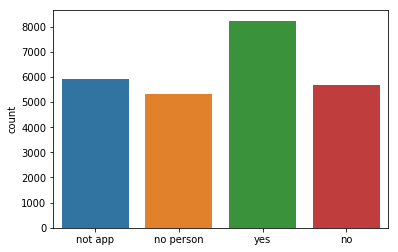

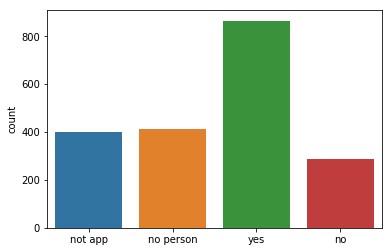

In [8]:
sns.countplot(Z_train)
plt.xticks(np.arange(len(label_names)), label_names)
plt.show()

sns.countplot(Z_test)
plt.xticks(np.arange(len(label_names)), label_names)
plt.show()

### Load annotations / Generate

In [8]:
from code.representation import *
from code.utils import *

# data from Amazon Mechanical Turk
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers_"+p_error+"_"+Q_s+".txt",dtype='int16')#not annotation symbol ==-1
#y_obs = y_obs[~mask_val]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
Kl = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",Kl)

Loading AMT data...
Remove 0 annotators that do not annotate on this set 
Shape (data,annotators):  (25137, 1389)
Classes:  4


In [ ]:
#every annotation is one annotator
total_annotations = T_weights.sum(axis=0)
new_annotations = np.ones((N, total_annotations),dtype='int16')*-1
t_aux = 0
for i in range(y_obs.shape[0]):
    for t in range(y_obs.shape[1]):
        if y_obs[i,t] != -1:
            new_annotations[i,t_aux] = y_obs[i,t]
            t_aux+=1
new_annotations.shape

In [30]:
np.savetxt(folder+"answers_v2.txt",new_annotations, delimiter=",", fmt="%i")

In [9]:
#generate conf matrix...
confe_matrix_R = np.zeros((T,Kl,Kl),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix_R[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix_R[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix_R[t,:,:][~mask_nan],axis=0)
    for value in np.arange(Kl)[mask_nan]:
        #how to fill where she not annotate?? -- 
        confe_matrix_R[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
        #confe_matrix[t,value,:] = mean_replace #Ours
    confe_matrix_R[t,:,:] = confe_matrix_R[t,:,:]/confe_matrix_R[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix_R

array([[[0.49019608, 0.23529412, 0.11764706, 0.15686275],
        [0.04166667, 0.625     , 0.1875    , 0.14583333],
        [0.        , 0.        , 0.8867925 , 0.11320755],
        [0.        , 0.        , 0.7906977 , 0.20930232]],

       [[1.        , 0.        , 0.        , 0.        ],
        [0.67741936, 0.29032257, 0.        , 0.03225806],
        [0.        , 0.        , 0.46666667, 0.53333336],
        [0.2       , 0.05      , 0.05      , 0.7       ]],

       [[0.5       , 0.5       , 0.        , 0.        ],
        [0.        , 1.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.5       , 0.5       ]],

       ...,

       [[0.25      , 0.25      , 0.25      , 0.25      ],
        [0.        , 1.        , 0.        , 0.        ],
        [0.25      , 0.25      , 0.25      , 0.25      ],
        [1.        , 0.        , 0.        , 0.        ]],

       [[0.        , 1.        , 0.        , 0.    

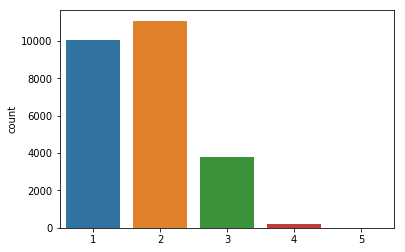

Minimum annotations in a example:  1
Maximum annotations in a example:  5
T data (expected value):  1.7667979472490751
Graphics of T weights


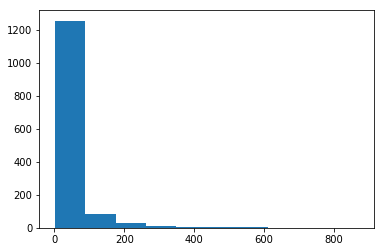

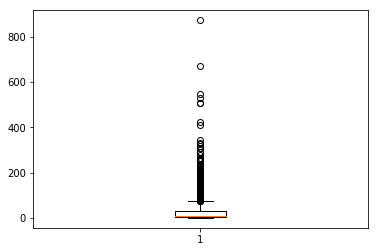

Minimum annotations by an annotator:  1
Maximum annotations by an annotator:  872
Mean annotations by an annotator:  31.974082073434126


In [10]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

#### Delta Convergence criteria

In [11]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,CNN_simple, RNN_simple, Clonable_Model

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [12]:
Z_train_onehot = keras.utils.to_categorical(Z_train, num_classes=Kl)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=True,drop=0.5) 
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])

clone_UB = Clonable_Model(model_UB)
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_val_pred = model_UB.predict_classes(Xstd_val)
Z_test_pred = model_UB.predict_classes(Xstd_test)

Trained IDeal Model, Epochs to converge = 4


In [52]:
Kl = Z_train.max()+1
Z_train_onehot = keras.utils.to_categorical(Z_train, num_classes=Kl)
Z_val_onehot = keras.utils.to_categorical(Z_val, num_classes=Kl)
Z_test_onehot = keras.utils.to_categorical(Z_test, num_classes=Kl)

In [53]:
model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,2,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["acc"])
model_UB.summary()
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total para

In [54]:
model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=True,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["acc"])
model_UB.summary()
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 66,692
Trainable params: 66,436
Non-trainable params: 256
_________________________________________________________________
Trai

In [55]:
model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,2,BN=True,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["acc"])
model_UB.summary()
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
__________

In [87]:
clone_UB = Clonable_Model(model_UB)
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_test_pred = model_UB.predict_classes(Xstd_test)

Trained IDeal Model, Epochs to converge = 4


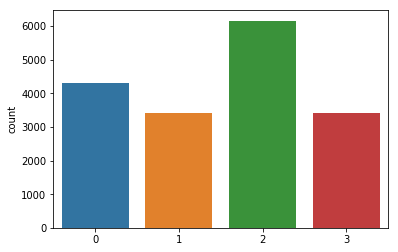

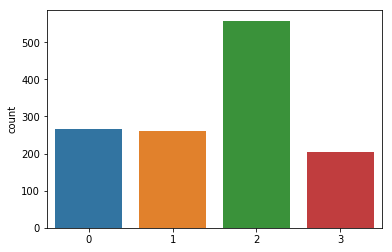

In [91]:
sns.countplot(Z_train_pred)
plt.show()
sns.countplot(Z_test_pred)
plt.show()

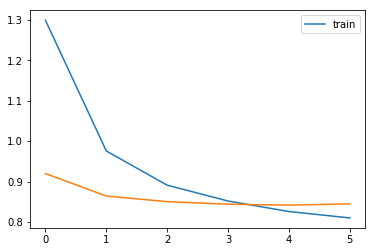

In [92]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

### Infer Labels (without predictive model)

In [13]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

if y_obs.shape[1] <= 12000:
    ds_labels,ds_conf = label_I.DS_labels()

Representation for MV in 1.095452 sec
Representation for DS in 0.981089 sec
Estimation MV in 0.001869 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -47583.25877114918
2 	 -46060.27884869213 	0.0155	0.319594	0.032007
3 	 -45625.268618768576 	0.0119	0.071859	0.009444
4 	 -45382.537427372146 	0.0071	0.064271	0.005320
5 	 -45225.3842405607 	0.0042	0.060685	0.003463
6 	 -45115.04263587003 	0.0029	0.057219	0.002440
7 	 -45034.08758969122 	0.0023	0.053829	0.001794
8 	 -44973.30313350427 	0.0022	0.050884	0.001350
9 	 -44926.03310724123 	0.0022	0.048181	0.001051
10 	 -44888.568921090526 	0.0022	0.045685	0.000834
11 	 -44857.94510470734 	0.0021	0.043438	0.000682
12 	 -44832.45612988966 	0.0021	0.041369	0.000568
13 	 -44810.89119053453 	0.0020	0.039196	0.000481
14 	 -44792.30425381032 	0.0020	0.036790	0.000415
15 	 -44776.02730837744 	0.0019	337.507660	0.000363
16 	 -44761.470048217336 	0.0019	0.032699	0.000325
17 	 -44748.23970376747 	0.0018	0.030968	0.000296
18 	 -44736.13917431224 	0.

In [14]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("F1 MV  on train:",f1_score(Z_train,mv_onehot.argmax(axis=1),average="macro"))

print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))
print("F1 D&S  on train:",f1_score(Z_train,ds_labels.argmax(axis=1),average="macro"))

ACC MV on train: 0.6065958547161555
F1 MV  on train: 0.585113124263393
ACC D&S on train: 0.5802601742451367
F1 D&S  on train: 0.5664530426344931


In [15]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(Xstd_train)
Z_val_pred = model_mvsoft.predict_classes(Xstd_val)
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)

Trained model over soft-MV, Epochs to converge = 4


In [21]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(Xstd_train)
Z_val_pred = model_mvhard.predict_classes(Xstd_val)
Z_test_pred = model_mvhard.predict_classes(Xstd_test)

Trained model over hard-MV, Epochs to converge = 4


In [23]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(Xstd_train)
Z_val_pred = model_ds.predict_classes(Xstd_val)
Z_test_pred = model_ds.predict_classes(Xstd_test)

Trained model over D&S, Epochs to converge = 4


### Raykar Model (joint predict model)

In [16]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (25137, 1389, 4)


In [36]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",128,1,BatchN=True,drop=0.5) #otro

logL_hists,i_r = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (1389, 4, 4)
Q estimate shape:  (25137, 4)
Iter 1/50 
M step: done,  E step: done //  (in 4.84 sec)	logL: -42530.879	
Iter 2/50 
M step: done,  E step: done //  (in 2.75 sec)	logL: -39742.289	Tol1: 0.06557	Tol2: 0.14487	
Iter 3/50 
M step: done,  E step: done //  (in 2.75 sec)	logL: -38427.207	Tol1: 0.03309	Tol2: 0.05606	
Iter 4/50 
M step: done,  E step: done //  (in 2.76 sec)	logL: -37400.230	Tol1: 0.02673	Tol2: 0.03464	
Iter 5/50 
M step: done,  E step: done //  (in 2.74 sec)	logL: -36646.758	Tol1: 0.02015	Tol2: 0.02812	
Finished training
Initializing new EM...
Betas shape:  (1389, 4, 4)
Q estimate shape:  (25137, 4)
Iter 1/50 
M step: done,  E step: done //  (in 4.67 sec)	logL: -42704.508	
Iter 2/50 
M step: done,  E step: done //  (in 2.76 sec)	logL: -39886.574	Tol1: 0.06599	Tol2: 0.14459	
Iter 3/50 
M step: done,  E step: done //  (in 2.76 sec)	logL: -38396.004	Tol1: 0.03737	Tol2: 0.05443	
Iter 4/50 
M s

M step: done,  E step: done //  (in 2.77 sec)	logL: -36755.102	Tol1: 0.01771	Tol2: 0.02854	
Finished training
Initializing new EM...
Betas shape:  (1389, 4, 4)
Q estimate shape:  (25137, 4)
Iter 1/50 
M step: done,  E step: done //  (in 4.70 sec)	logL: -42112.789	
Iter 2/50 
M step: done,  E step: done //  (in 2.77 sec)	logL: -39445.402	Tol1: 0.06334	Tol2: 0.14876	
Iter 3/50 
M step: done,  E step: done //  (in 2.76 sec)	logL: -38152.441	Tol1: 0.03278	Tol2: 0.05360	
Iter 4/50 
M step: done,  E step: done //  (in 2.76 sec)	logL: -37336.184	Tol1: 0.02139	Tol2: 0.03432	
Iter 5/50 
M step: done,  E step: done //  (in 2.75 sec)	logL: -36718.488	Tol1: 0.01654	Tol2: 0.02411	
Finished training
Initializing new EM...
Betas shape:  (1389, 4, 4)
Q estimate shape:  (25137, 4)
Iter 1/50 
M step: done,  E step: done //  (in 4.70 sec)	logL: -42587.043	
Iter 2/50 
M step: done,  E step: done //  (in 2.76 sec)	logL: -39637.816	Tol1: 0.06925	Tol2: 0.14562	
Iter 3/50 
M step: done,  E step: done //  (in 

In [37]:
Z_train_p = raykarMC.get_predictions(Xstd_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_val_pred = raykarMC.get_predictions(Xstd_val).argmax(axis=-1)
Z_test_pred = raykarMC.get_predictions(Xstd_test).argmax(axis=-1)

### Our Proposed

In [17]:
from code.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

In [18]:
""" AÑADIR A ARCHIVO GROUPS..."""
def define_uniform_groups(power, r, M):
    R_total = r.sum()
    uniform_groups = np.asarray([power*R_total/M for _ in range(M)])
    return uniform_groups


#get our representation 
r_obs = set_representation(y_obs,"repeat")
#r_obs = label_I.y_obs_repeat.copy()

confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 0 1 2]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 1 0 0]
 [0 0 1 0]
 [2 0 0 0]]
shape: (25137, 4)


Normalized entropy (0-1) of repeats annotations: 0.22649788216219027


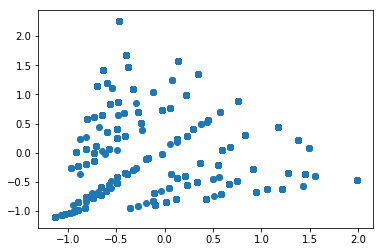

In [27]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

from code.MixtureofGroups import *
predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.041659 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (17363, 4)
Betas:  (5, 4, 4)
Q estimate:  (17363, 4, 5, 4)
Iter 1/0
M step: done,  E step: done //  (in 1.06 sec)	logL: -67392.492	
Finished training!


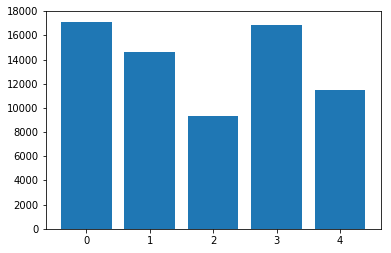

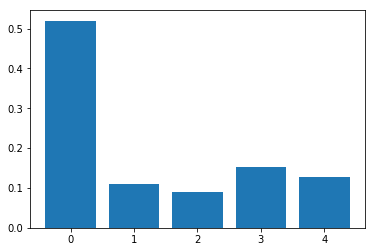

In [21]:
gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=5,epochs=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=True,drop=0.5)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())
plt.show()

In [20]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

459


NameError: name 'logL_Mchange' is not defined

1, 2 o 3...

In [30]:
M_seted = 3 #??

uniform = False
if uniform:
    uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
    print(uniform_groups)

In [31]:
gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=True,drop=0.5)

if uniform:
    gMixture_Global.define_priors("laplace")
    gMixture_Global.define_priors(uniform_groups)

gMixture_Global.lambda_random = False 
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,
                                               batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*5/3)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.061195 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (25137, 4)
Betas:  (3, 4, 4)
Q estimate:  (25137, 4, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 5.36 sec)	logL: -48850.147	
Iter 2/50
M step: done,  E step: done //  (in 1.61 sec)	logL: -47276.227	Tol1: 0.03222	Tol2: 0.30078	Tol3: 0.06918	
Iter 3/50
M step: done,  E step: done //  (in 1.61 sec)	logL: -46689.384	Tol1: 0.01241	Tol2: 0.16312	Tol3: 0.01269	
Iter 4/50
M step: done,  E step: done //  (in 1.61 sec)	logL: -46337.897	Tol1: 0.00753	Tol2: 0.11169	Tol3: 0.00572	
Iter 5/50
M step: done,  E step: done //  (in 1.61 sec)	logL: -46050.074	Tol1: 0.00621	Tol2: 0.11160	Tol3: 0.02064	
Iter 6/50
M step: done,  E step: done //  (in 1.58 sec)	logL: -45765.022	Tol1: 0.00619	Tol2: 0.08859	Tol3: 0.01584	
Iter 7/50
M step: done,  E step: done //  (in 1.60 sec)	logL: -45541.558	Tol1: 0.00488	Tol2: 0.08461	Tol3: 0.0187

M step: done,  E step: done //  (in 1.54 sec)	logL: -44740.379	Tol1: 0.00655	Tol2: 0.05819	Tol3: 0.01116	
Iter 11/50
M step: done,  E step: done //  (in 1.52 sec)	logL: -44468.301	Tol1: 0.00608	Tol2: 0.05176	Tol3: 0.00412	
Iter 12/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -44217.387	Tol1: 0.00564	Tol2: 0.04304	Tol3: 0.00372	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.058564 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (25137, 4)
Betas:  (3, 4, 4)
Q estimate:  (25137, 4, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 2.82 sec)	logL: -48875.128	
Iter 2/50
M step: done,  E step: done //  (in 1.46 sec)	logL: -47304.176	Tol1: 0.03214	Tol2: 0.29612	Tol3: 0.05883	
Iter 3/50
M step: done,  E step: done //  (in 1.51 sec)	logL: -46838.652	Tol1: 0.00984	Tol2: 0.14442	Tol3: 0.00394	
Iter 4/50
M step: done,  E step: done //  (in 1.46 sec)	logL: -46500.766	Tol1: 0.00721	Tol2: 0.10543	Tol3: 0.00630	
Iter 5/50
M step: done,  E

M step: done,  E step: done //  (in 1.47 sec)	logL: -47342.462	Tol1: 0.03837	Tol2: 0.32178	Tol3: 0.08700	
Iter 3/50
M step: done,  E step: done //  (in 1.47 sec)	logL: -46855.662	Tol1: 0.01028	Tol2: 0.14578	Tol3: 0.01638	
Iter 4/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -46446.643	Tol1: 0.00873	Tol2: 0.12726	Tol3: 0.00813	
Iter 5/50
M step: done,  E step: done //  (in 1.47 sec)	logL: -46132.351	Tol1: 0.00677	Tol2: 0.09213	Tol3: 0.00860	
Iter 6/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -45844.751	Tol1: 0.00623	Tol2: 0.08069	Tol3: 0.00972	
Iter 7/50
M step: done,  E step: done //  (in 1.46 sec)	logL: -45574.518	Tol1: 0.00589	Tol2: 0.07534	Tol3: 0.01263	
Iter 8/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -45299.343	Tol1: 0.00604	Tol2: 0.05505	Tol3: 0.00548	
Iter 9/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -45054.008	Tol1: 0.00542	Tol2: 0.08467	Tol3: 0.01141	
Iter 10/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -44712.494	Tol1: 0.

M step: done,  E step: done //  (in 1.50 sec)	logL: -44259.093	Tol1: 0.00724	Tol2: 0.07252	Tol3: 0.02347	
Iter 13/50
M step: done,  E step: done //  (in 1.47 sec)	logL: -44171.815	Tol1: 0.00197	Tol2: 0.04358	Tol3: 0.00662	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.060525 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (25137, 4)
Betas:  (3, 4, 4)
Q estimate:  (25137, 4, 3, 4)
Iter 1/50
M step: done,  E step: done //  (in 2.80 sec)	logL: -48691.763	
Iter 2/50
M step: done,  E step: done //  (in 1.46 sec)	logL: -47180.140	Tol1: 0.03104	Tol2: 0.28934	Tol3: 0.05762	
Iter 3/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -46712.810	Tol1: 0.00991	Tol2: 0.15023	Tol3: 0.00386	
Iter 4/50
M step: done,  E step: done //  (in 1.47 sec)	logL: -46332.347	Tol1: 0.00814	Tol2: 0.12368	Tol3: 0.01197	
Iter 5/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -46051.872	Tol1: 0.00605	Tol2: 0.09928	Tol3: 0.01362	
Iter 6/50
M step: done,  E 

M step: done,  E step: done //  (in 1.47 sec)	logL: -43237.061	Tol1: 0.00633	Tol2: 0.05056	Tol3: 0.00976	
Iter 16/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -42884.528	Tol1: 0.00815	Tol2: 0.06379	Tol3: 0.00729	
Iter 17/50
M step: done,  E step: done //  (in 1.47 sec)	logL: -42694.068	Tol1: 0.00444	Tol2: 0.05257	Tol3: 0.01651	
Iter 18/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -42565.462	Tol1: 0.00301	Tol2: 0.05601	Tol3: 0.00467	
Iter 19/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -42188.502	Tol1: 0.00886	Tol2: 0.06480	Tol3: 0.01916	
Iter 20/50
M step: done,  E step: done //  (in 1.53 sec)	logL: -41885.895	Tol1: 0.00717	Tol2: 0.06131	Tol3: 0.00689	
Iter 21/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -41719.936	Tol1: 0.00396	Tol2: 0.03678	Tol3: 0.01499	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.058275 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (25137, 4)
Betas:  (3, 4, 4)
Q estimate

In [32]:
Z_train_p = gMixture_Global.get_predictions(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_val_p = gMixture_Global.get_predictions(Xstd_val)
Z_val_pred = Z_val_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

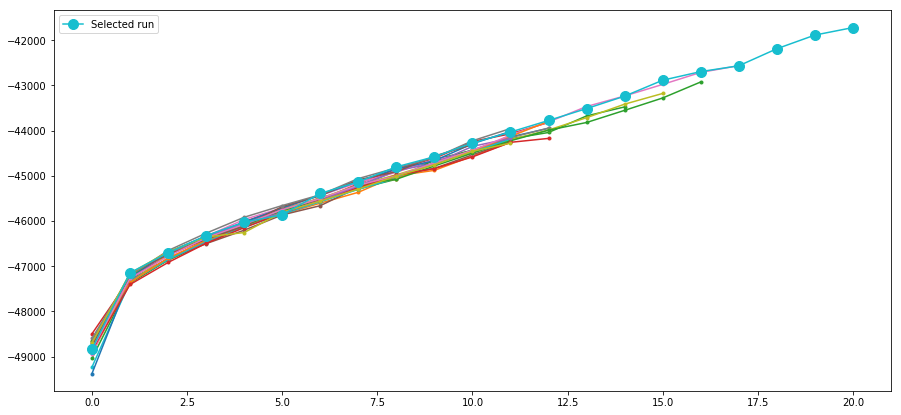

In [33]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [28]:
Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
T_idx_unique = np.arange(T).reshape(-1,1)

A = keras.utils.to_categorical(np.arange(T), num_classes=T) #fast way
print("shape of annotator representation (T, R_t)=", A.shape)

shape of annotator representation (T, R_t)= (1389, 1389)


shape of annotator representation (T, R_t)= (1389, 16)


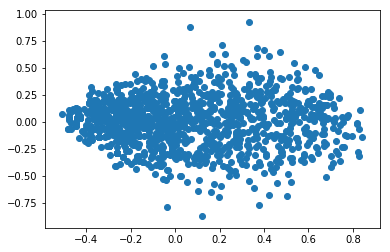

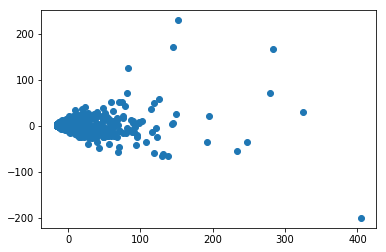

array([[27., 42., 96., 30.],
       [50., 10.,  8., 23.],
       [ 2.,  3.,  2.,  5.],
       ...,
       [ 1.,  3.,  0.,  0.],
       [ 0.,  3.,  1.,  0.],
       [ 0.,  1.,  0.,  0.]])

In [29]:
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, r_obs.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten
#A_rep = np.zeros((conf_mat.shape[0], Kl))
#for t in range(A_rep.shape[0]):
#    A_rep[t] = JS_confmatrixs(conf_mat_norm[t], np.identity(Kl),raw=True) #distancia a I (MV)
    
print("shape of annotator representation (T, R_t)=", A_rep.shape)

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()


A_rep = np.zeros((y_obs.shape[1], Kl))
for i in range(N):
    for l, t_idx in enumerate(T_idx[i]):
        obs_t = Y_ann_train[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
    
from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()
A_rep

In [35]:
#different M_seted??
M_seted = 3

In [ ]:
gMixture_Ind1 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind1.define_model("mlp",128,1,BatchN=True,drop=0.5)

#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
gMixture_Ind1.define_model_group("perceptron",T, M_seted, embed=True, embed_M=A, BatchN=True,bias=False)

logL_hists,i = gMixture_Ind1.multiples_run(1,Xstd_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL*5/3)

In [171]:
Z_train_p = gMixture_Ind1.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_val_p = gMixture_Ind1.get_predictions_z(Xstd_val)
Z_val_pred = Z_val_p.argmax(axis=-1)
Z_test_p = gMixture_Ind1.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind1.get_predictions_g(T_idx_unique) 

In [38]:
A_rep = A_rep/A_rep.sum(axis=-1,keepdims=True)
A_rep

array([[0.12162162, 0.2027027 , 0.51351351, 0.16216216],
       [0.52857143, 0.08571429, 0.1       , 0.28571429],
       [0.13333333, 0.13333333, 0.53333333, 0.2       ],
       ...,
       [0.2       , 0.8       , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 1.        , 0.        , 0.        ]])

In [ ]:
gMixture_Ind3 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind3.define_model("mlp",128,1,BatchN=True,drop=0.5)
gMixture_Ind3.define_model_group("mlp", A_rep.shape[1], Kl*M_seted, 1, BatchN=False, embed=False) #con BN y A norm

logL_hists,i_r = gMixture_Ind3.multiples_run(1,Xstd_train,Y_ann_train, T_idx, A=A_rep, batch_size=BATCH_SIZE,
                                   pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL*5/3) 

In [46]:
Z_train_p = gMixture_Ind3.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_val_p = gMixture_Ind3.get_predictions_z(Xstd_val)
Z_val_pred = Z_val_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind3.get_predictions_g(A_rep) 

### Compare trained models

In [19]:
#Import it:
from code.evaluation import Evaluation_metrics

colors = {0: 'b', 1:'r' ,2:'g'}
marker_s = {0: 'X', 1:'o', 2:'P'}

def plot_alphas(alphas_training):
    values = np.asarray(alphas_training)
    if len(values.shape) == 3:
        group_f = values[-1].argmax(axis=-1) #coloreado por el grupo del final..
        
        for m in range(M_seted):
            plt.figure(figsize=(15,7))
            for t in range(values.shape[1]):
                plt.plot(values[:,t,m], color=colors[group_f[t]], markersize=5)
            plt.title("Group "+str(m))
            plt.show()

        plt.figure(figsize=(15,10))
        for t in range(values.shape[1]):
            grupos_t_train = values[:,t,:].argmax(axis=-1)+t/values.shape[1]
            plt.plot(grupos_t_train, markersize=5, color=colors[group_f[t]])
            #plt.plot(grupos_t_train, markersize=5, marker=marker_s[group_f[t]])

        for m in range(M_seted+1):
            plt.hlines(m, 0,values.shape[0], linestyles="dashed")
        plt.show()
        
    else:
        plt.figure(figsize=(15,7))
        for m in range(M_seted):
            plt.plot(values[:,m], color=colors[m], markersize=5, label="Group "+str(m))
        plt.legend()
        plt.show()

In [25]:
aux_tr = []
aux_te = []
eps = []
for _ in range(20):
    model_UB = clone_UB.get_model()
    model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
    hist = model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
    Z_train_pred = model_UB.predict_classes(Xstd_train)
    Z_test_pred = model_UB.predict_classes(Xstd_test)

    evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0], plot=False)
    aux_tr += evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)
    aux_te += evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)
    eps.append(len(hist.epoch))
    
print("Epochs: ",np.mean(eps))
final_tr_m = get_mean_dataframes(aux_tr)#.to_csv("LabelMe_Ideal_train.csv",index=False)
final_tr_std = get_mean_dataframes(aux_tr, mean_std=False)#.to_csv("LabelMe_Ideal_train_std.csv",index=False)
final_te_m = get_mean_dataframes(aux_te)#.to_csv("LabelMe_Ideal_test.csv",index=False)
final_te_std = get_mean_dataframes(aux_te, mean_std=False)#.to_csv("LabelMe_Ideal_test_std.csv",index=False)

final_tr_m.merge(final_tr_std.iloc[:,1:], left_index=True, right_index=True)

Epochs:  4.4


,,Accuracy_x,F1 (micro)_x,F1 (macro)_x,Accuracy_y,F1 (micro)_y,F1 (macro)_y
0,All,0.674625,0.674625,0.660171,0.004145,0.004145,0.005267


In [26]:
final_te_m.merge(final_te_std.iloc[:,1:], left_index=True, right_index=True)

,,Accuracy_x,F1 (micro)_x,F1 (macro)_x,Accuracy_y,F1 (micro)_y,F1 (macro)_y
0,All,0.787348,0.787348,0.745004,0.003944,0.003944,0.006864


*** Soft-Majority (Train with softMV) ***
Train
Calculate confusion matrix on repeat version


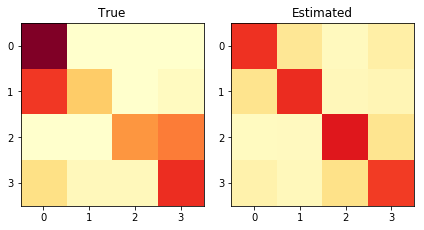

JS divergence: 0.139	Norm Frobenius: 0.225


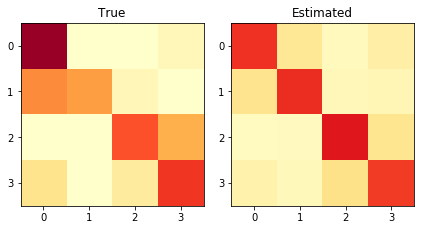

JS divergence: 0.085	Norm Frobenius: 0.149


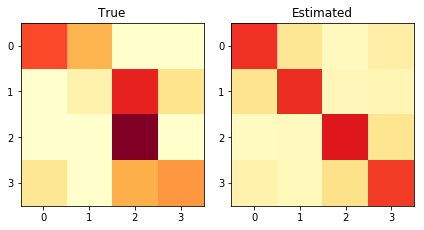

JS divergence: 0.215	Norm Frobenius: 0.264


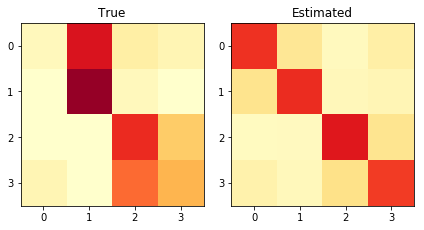

JS divergence: 0.183	Norm Frobenius: 0.270


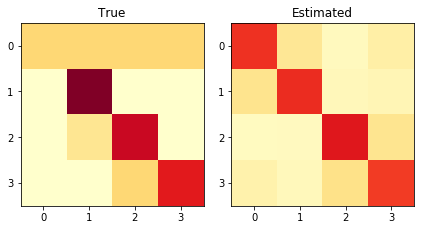

JS divergence: 0.135	Norm Frobenius: 0.171


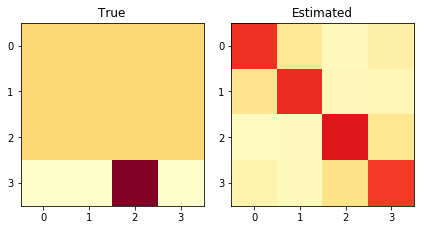

JS divergence: 0.301	Norm Frobenius: 0.356


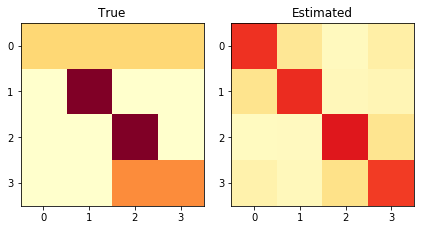

JS divergence: 0.148	Norm Frobenius: 0.196


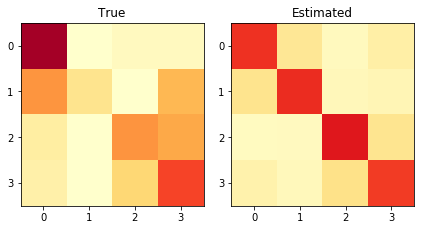

JS divergence: 0.126	Norm Frobenius: 0.207


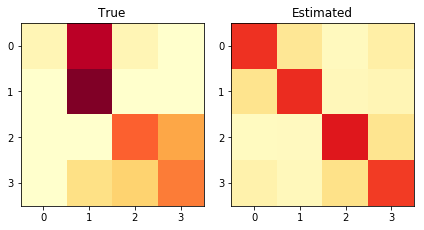

JS divergence: 0.203	Norm Frobenius: 0.273


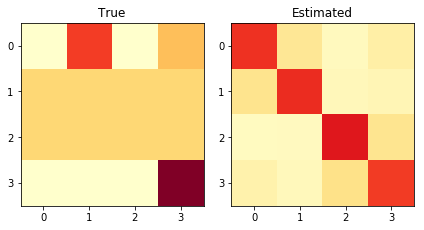

JS divergence: 0.285	Norm Frobenius: 0.316


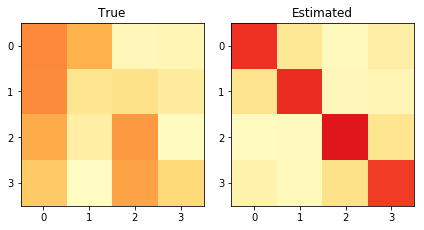

JS divergence: 0.159	Norm Frobenius: 0.254


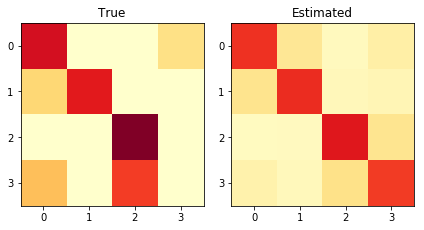

JS divergence: 0.205	Norm Frobenius: 0.235


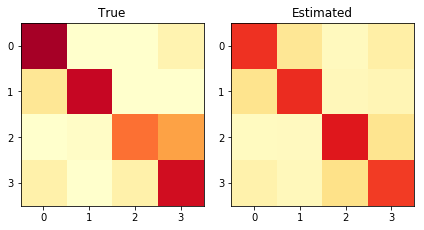

JS divergence: 0.071	Norm Frobenius: 0.123


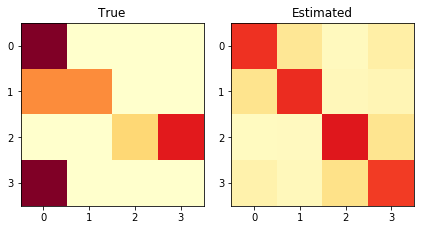

JS divergence: 0.337	Norm Frobenius: 0.370


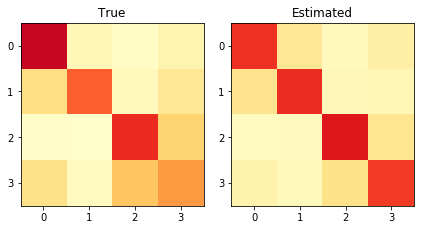

JS divergence: 0.025	Norm Frobenius: 0.092
Calculate confusion matrix on global version


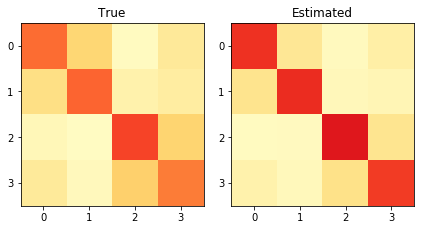

JS divergence: 0.015	Norm Frobenius: 0.079
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.6151,0.6151,0.5869,0.2731,0.2259,0.2136,0.1517,0.0791,0.0153


Val
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7485,0.7485,0.6869


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7485,0.7485,0.6869


In [20]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)

print("Val")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
Calculate confusion matrix on repeat version


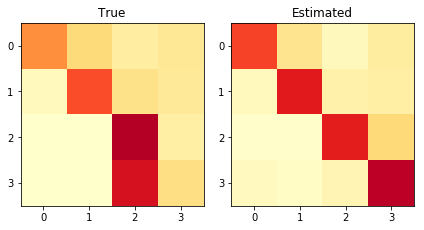

JS divergence: 0.126	Norm Frobenius: 0.256


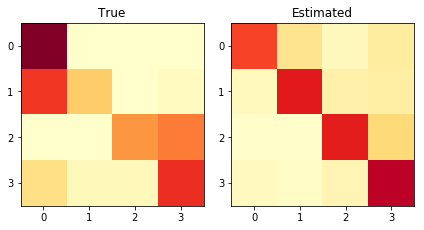

JS divergence: 0.180	Norm Frobenius: 0.253


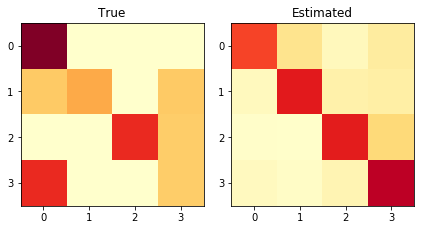

JS divergence: 0.209	Norm Frobenius: 0.276


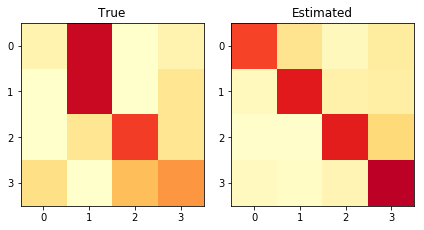

JS divergence: 0.172	Norm Frobenius: 0.259


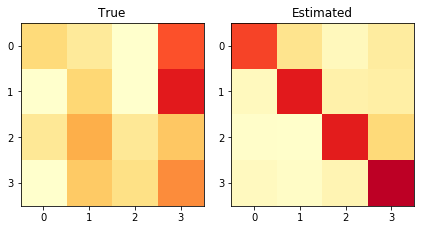

JS divergence: 0.289	Norm Frobenius: 0.340


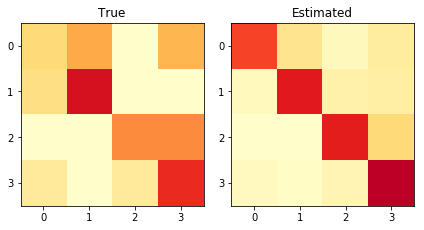

JS divergence: 0.105	Norm Frobenius: 0.176


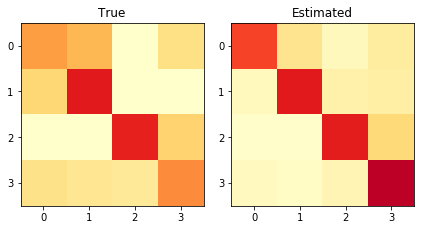

JS divergence: 0.093	Norm Frobenius: 0.145


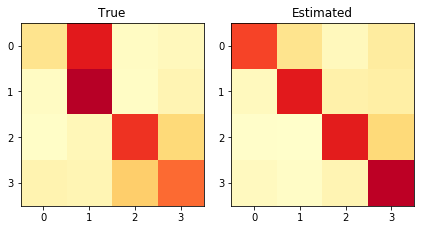

JS divergence: 0.098	Norm Frobenius: 0.213


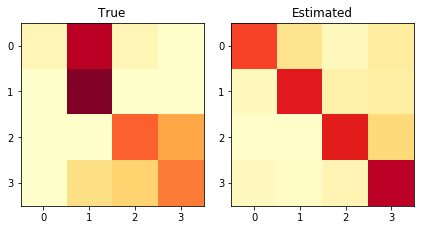

JS divergence: 0.193	Norm Frobenius: 0.271


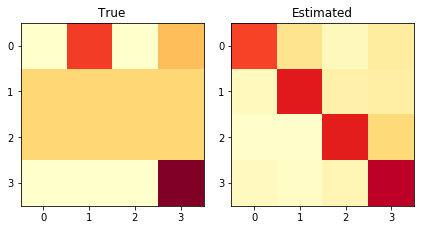

JS divergence: 0.265	Norm Frobenius: 0.299


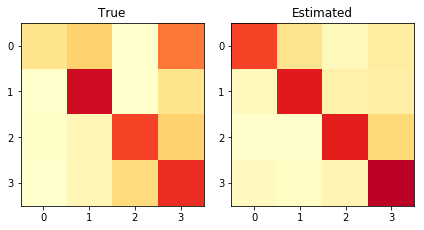

JS divergence: 0.100	Norm Frobenius: 0.176


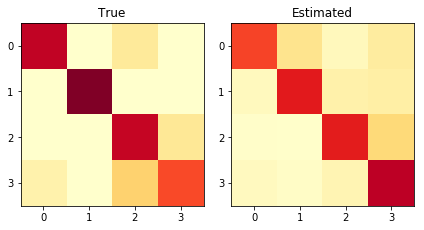

JS divergence: 0.102	Norm Frobenius: 0.137


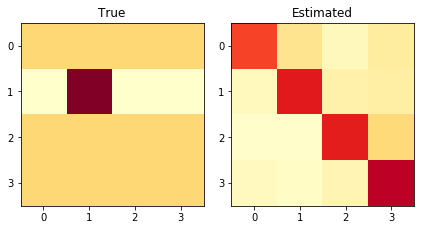

JS divergence: 0.225	Norm Frobenius: 0.273


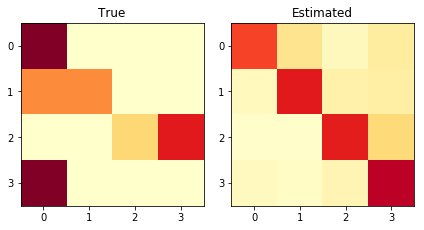

JS divergence: 0.393	Norm Frobenius: 0.408


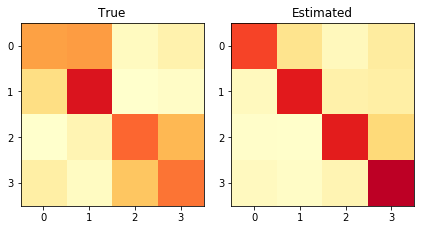

JS divergence: 0.081	Norm Frobenius: 0.154
Calculate confusion matrix on global version


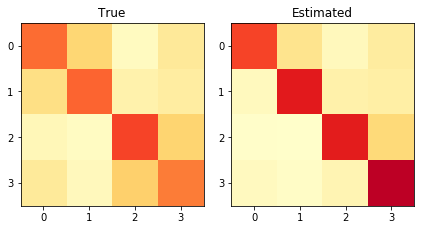

JS divergence: 0.046	Norm Frobenius: 0.125
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.6031,0.6031,0.5089,0.2893,0.2434,0.2363,0.1735,0.1254,0.0464


Val
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7424,0.7424,0.6025


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7424,0.7424,0.6025


In [22]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_onehot, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)

print("Val")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
Calculate confusion matrix on repeat version


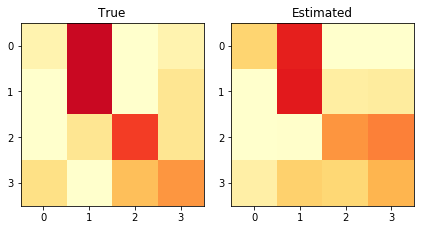

JS divergence: 0.112	Norm Frobenius: 0.151


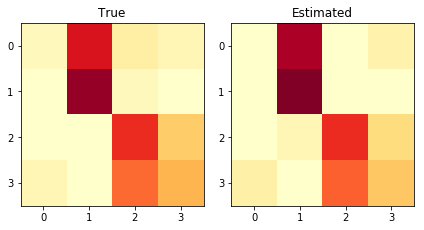

JS divergence: 0.036	Norm Frobenius: 0.056


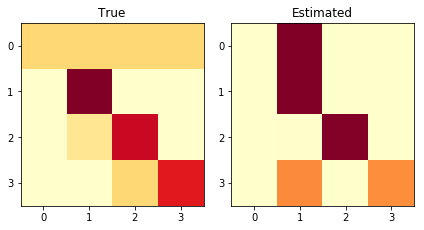

JS divergence: 0.252	Norm Frobenius: 0.272


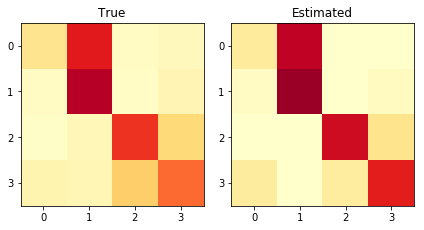

JS divergence: 0.041	Norm Frobenius: 0.082


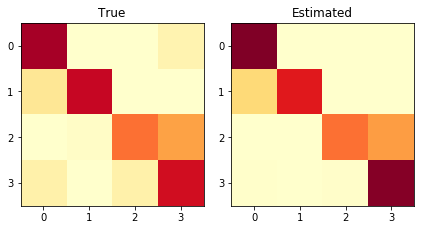

JS divergence: 0.031	Norm Frobenius: 0.068


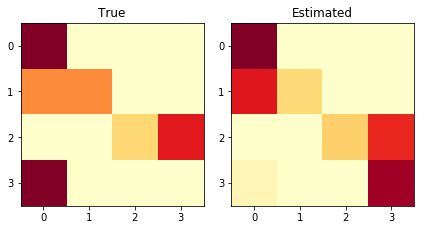

JS divergence: 0.217	Norm Frobenius: 0.342


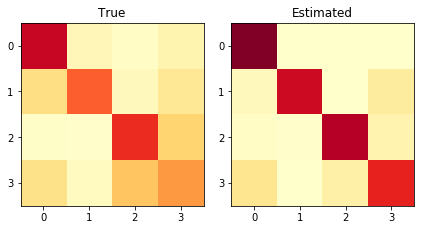

JS divergence: 0.070	Norm Frobenius: 0.137


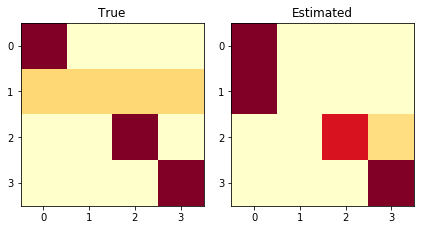

JS divergence: 0.166	Norm Frobenius: 0.229


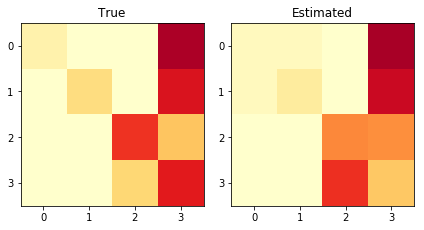

JS divergence: 0.058	Norm Frobenius: 0.173


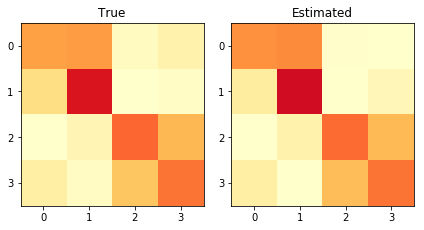

JS divergence: 0.019	Norm Frobenius: 0.040


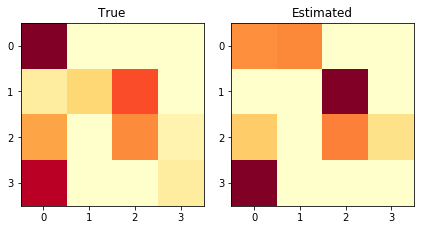

JS divergence: 0.156	Norm Frobenius: 0.223


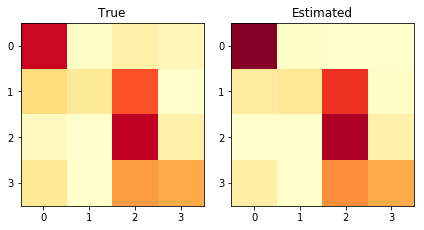

JS divergence: 0.027	Norm Frobenius: 0.059


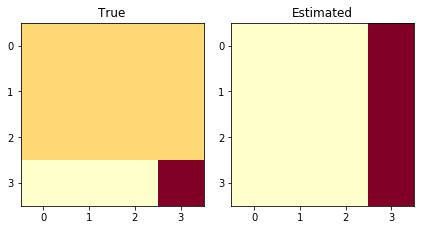

JS divergence: 0.412	Norm Frobenius: 0.375


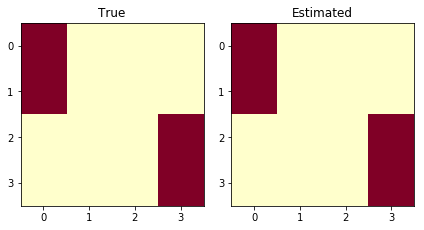

JS divergence: 0.000	Norm Frobenius: 0.000


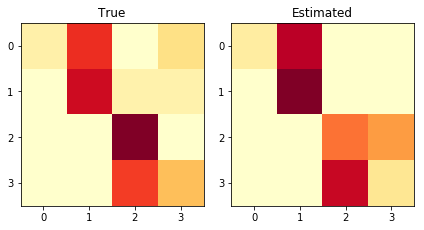

JS divergence: 0.126	Norm Frobenius: 0.191
Calculate confusion matrix on global version


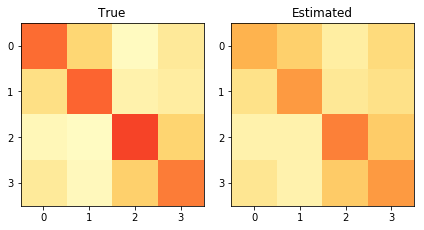

JS divergence: 0.022	Norm Frobenius: 0.082
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.6188,0.6188,0.5633,0.2592,0.2269,0.1404,0.0874,0.0824,0.0217


Val
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7576,0.7576,0.6692


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7576,0.7576,0.6692


In [24]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))

print("Val")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train
Calculate confusion matrix on repeat version


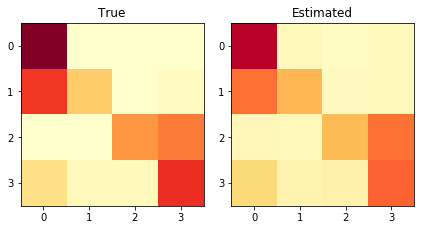

JS divergence: 0.040	Norm Frobenius: 0.070


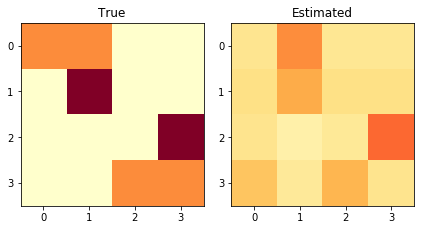

JS divergence: 0.295	Norm Frobenius: 0.268


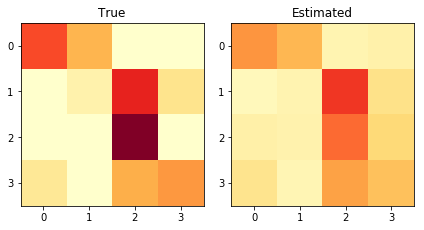

JS divergence: 0.105	Norm Frobenius: 0.145


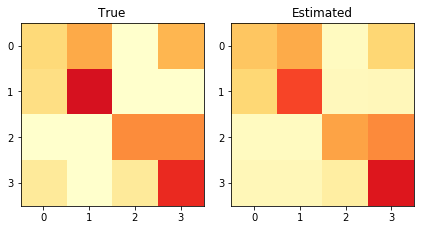

JS divergence: 0.041	Norm Frobenius: 0.064


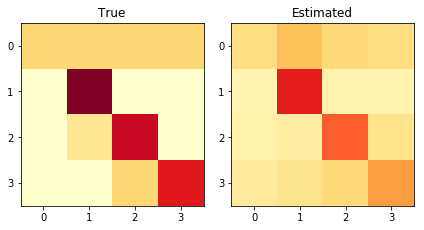

JS divergence: 0.124	Norm Frobenius: 0.147


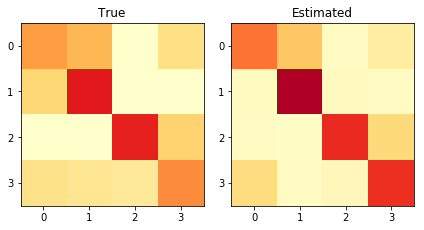

JS divergence: 0.056	Norm Frobenius: 0.101


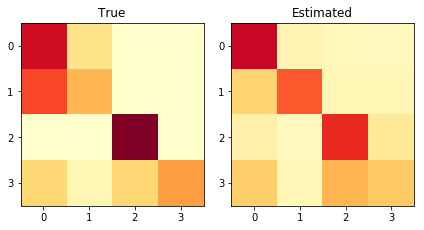

JS divergence: 0.098	Norm Frobenius: 0.154


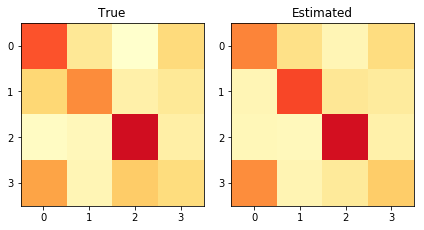

JS divergence: 0.029	Norm Frobenius: 0.081


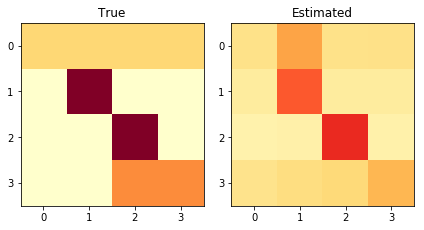

JS divergence: 0.165	Norm Frobenius: 0.181


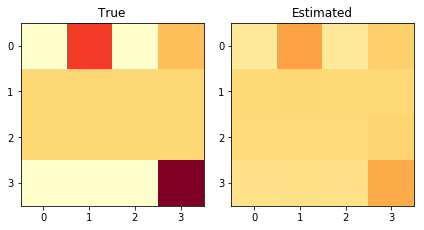

JS divergence: 0.140	Norm Frobenius: 0.191


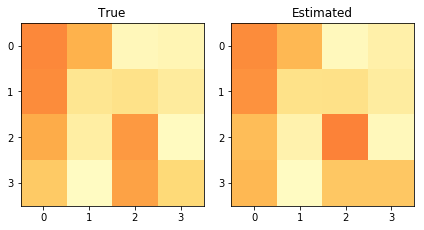

JS divergence: 0.005	Norm Frobenius: 0.045


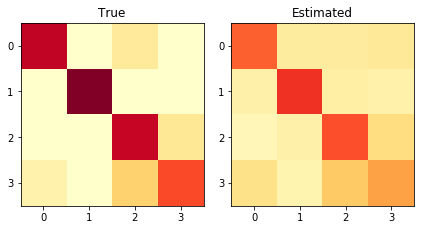

JS divergence: 0.124	Norm Frobenius: 0.151


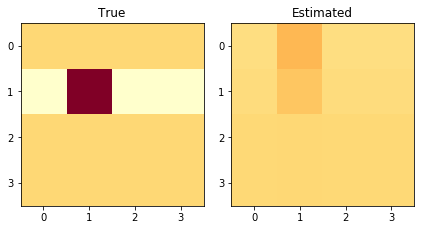

JS divergence: 0.123	Norm Frobenius: 0.201


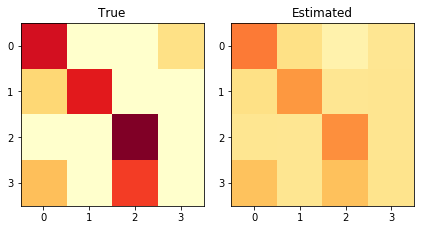

JS divergence: 0.225	Norm Frobenius: 0.221


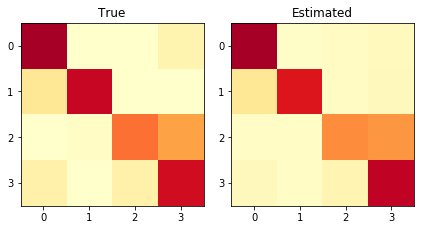

JS divergence: 0.023	Norm Frobenius: 0.037
Calculate confusion matrix on global version


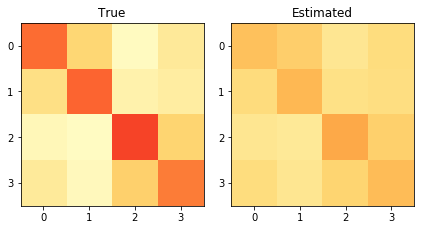

JS divergence: 0.059	Norm Frobenius: 0.137
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(G) NormF,(G) JS
0,All,0.6457,0.6457,0.6292,0.1923,0.1569,0.1371,0.0586


Val
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.782,0.782,0.741


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.782,0.782,0.741


In [38]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
#prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

#results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Val")
results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs, y_o_groups=y_o_groups,# yo_pred=prob_Yxt,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

#results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Val")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val,data=Z_val_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [40]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #groups uniform...

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

NameError: name 'Evaluation_metrics' is not defined

In [ ]:
evaluate = Evaluation_metrics(gMixture_Ind1,'our1') 
aux = gMixture_Ind1.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=False,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
prob_Yz = gMixture_Ind1.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual-T multiples runs***") #lambda = 1

print("Train")
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)


print("Val")
c_M = gMixture_Ind1.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val,data=Z_val_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=False,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual-K multiples runs***") #lambda = 1

print("Train")
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)


print("Val")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val,data=Z_val_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [43]:
plot_alphas(gMixture_Ind1.alphas_training)

NameError: name 'plot_alphas' is not defined

In [44]:
plot_alphas(gMixture_Ind3.alphas_training)

NameError: name 'plot_alphas' is not defined

### project confusion matrices

In [42]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_IT = flatten_conf(gMixture_Ind1.get_confusionM())
centroids_plot_IK = flatten_conf(gMixture_Ind3.get_confusionM())
global_plot = (confe_matrix_G.flatten()).reshape(1,-1)

from sklearn.decomposition import PCA
model = PCA(2)
model.fit(to_plot) 

to_plot = model.transform(to_plot) 
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_IT = model.transform(centroids_plot_IT)
centroids_plot_IK = model.transform(centroids_plot_IK)
global_plot = model.transform(global_plot)

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Groups Global", edgecolor='black')
plt.scatter(centroids_plot_IT[:,0], centroids_plot_IT[:,1],s=150, marker="X", color='purple',label="Groups Indiv model-T", edgecolor='black')
plt.scatter(centroids_plot_IK[:,0], centroids_plot_IK[:,1], s=150, marker="X", color='hotpink',label="Groups Indiv model-K", edgecolor='black')
#plt.scatter(global_plot[:,0], global_plot[:,1],label="Global")

plt.legend()
plt.show()#nuevo

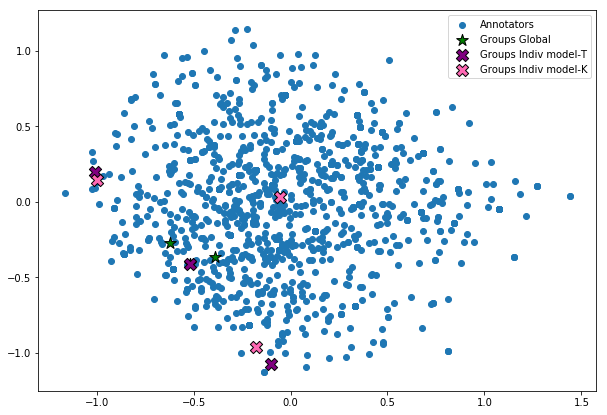

In [43]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Groups Global", edgecolor='black')
plt.scatter(centroids_plot_IT[:,0], centroids_plot_IT[:,1],s=150, marker="X", color='purple',label="Groups Indiv model-T", edgecolor='black')
plt.scatter(centroids_plot_IK[:,0], centroids_plot_IK[:,1], s=150, marker="X", color='hotpink',label="Groups Indiv model-K", edgecolor='black')
#plt.scatter(global_plot[:,0], global_plot[:,1],label="Global")

plt.legend()
plt.show()#nuevo